In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from config import RESULTS, FIGURES
from code_.tools.plotting import *
from code_.model_activations.configs import model_cfg

In [2]:
models_features_config = {
    'fully_connected': {'multiplier': 1},
    'vit': {'multiplier': 196},
    'expansion': {'multiplier': 36},
}

def load_and_prepare_data(model_name, multiplier, dataset, region):
    filepath = os.path.join(RESULTS, f'bootstrap-results-{model_name}-{dataset}-{region}.csv')
    df = pd.read_csv(filepath)
    df['model'] = model_name
    df['features'] = df['features'].apply(lambda x: int(x) * multiplier)
    df['score'] = df['score'].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
    return df

# Main results

In [3]:
DATASET = 'naturalscenes' # one of ['majajhong', 'naturalscenes']
regions = ['early visual stream', 'midventral visual stream','ventral visual stream'] 
# for majajhong: [V4,IT], for naturalscenes: [early visual stream, midventral visual stream, ventral visual stream]

In [4]:
# DATASET = 'majajhong'#, 'naturalscenes']
# regions = ['V4','IT']

In [5]:
# untrained models results
all_dfs = []
for region in regions:
    for model_name, config in models_features_config.items():
        features_list = model_cfg[DATASET]['models'][model_name]['features']
        df_model = load_and_prepare_data(model_name, config['multiplier'], DATASET, region)
        df_model['region'] = region
        all_dfs.append(df_model)

# Combine all dataframes and reset index
df = pd.concat(all_dfs).reset_index(drop=True)
# from each untrained model family take the largest
df  = df[df.features.isin([2352, 117600, 108, 108000])]


In [6]:
# SOTA models results

models = ['alexnet_untrained','alexnet_trained','vit_untrained', 'vit_trained', 'resnet50_trained']

for region in regions:
    for model in models:
        
        # alexnet data
        df_model = pd.read_csv(os.path.join(RESULTS, f'bootstrap-results-{model}-{DATASET}-{region}.csv'))
        df_model['score'] = df_model['score'].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
        df_model['region'] = region

        df = pd.concat([df, df_model], ignore_index=True)

In [7]:
# noise ceiling results
for region in regions:        
    # alexnet data
    file_path = os.path.join(RESULTS, f'nc-results-{DATASET}-{region}.csv')
    df_nc = pd.read_csv(file_path)  
    df = pd.concat([df, df_nc], ignore_index=True)

In [8]:
names ={'fully_connected':'FC',
        'expansion':'Conv',
        'vit':'Transformer',
        'alexnet_untrained': 'AlexNet Untrained',
        'alexnet_trained':'AlexNet',
        'vit_trained': 'ViT',
        'vit_untrained': 'ViT Untrained',
        'resnet50_trained': 'BarlowTwins ResNet50',
        'noise_ceiling': 'Noise Ceiling'
        }

df['model'] = df['model'].map(names)


In [9]:
df['name'] = df[['model','features']].apply((lambda x: x.model if x.model not in ['FC','Conv', 'Transformer'] else (x.model + ' S') if x.features in [2352,108] else (x.model + ' L')), axis=1)

In [10]:

palette = {
    'Conv S':     '#A8DADC',  # eggshell blue
    'Conv L':     '#1D3557',  # storm-blue navy

    'Transformer S':       '#F4A261',  # pale sand
    'Transformer L':       '#D17134',  # driftwood brown-orange

    'FC S':                '#E9C46A',  # soft dune yellow
    'FC L':                '#A0821F',  # deep mustard

    'AlexNet':                 '#596275',  # slate gray
    'AlexNet Untrained':       '#A9B2BC',  # light steel gray

    'ViT':                     '#6A4C93',  # twilight purple
    'ViT Untrained':           '#B8A9C9',  # lilac mist

    'BarlowTwins ResNet50':    '#2A9D8F',  # teal wave

    'Noise Ceiling':           '#000000',  # black
}

df['color'] = df['name'].map(palette)

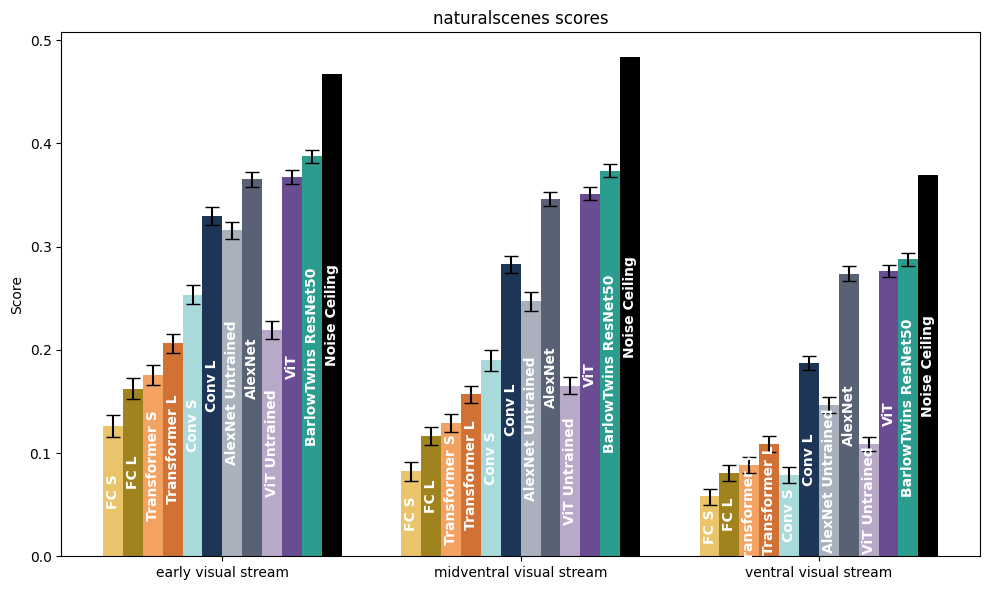

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Unique regions (groups) and models (bars within each group).
models = df['name'].unique()
n_regions = len(regions)
n_models = len(models)

# Width for each group and each bar within a group.
group_width = 0.8  # total width per group
bar_width = group_width / n_models

# x positions for each group.
x = np.arange(n_regions)

fig, ax = plt.subplots(figsize=(10, 6))

# Loop over each model to plot its bars.
for i, model in enumerate(models):
    scores = []
    lower_errors = []
    upper_errors = []
    colors = []
    for region in regions:
        row = df[(df['region'] == region) & (df['name'] == model)]
        if not row.empty:
            score = row['score'].values[0]
            # Compute error bars as differences.
            lower_err = score - row['lower'].values[0]
            upper_err = row['upper'].values[0] - score
            col = row['color'].values[0]
        else:
            score = np.nan
            lower_err = 0
            upper_err = 0
            col = 'grey'
        scores.append(score)
        lower_errors.append(lower_err)
        upper_errors.append(upper_err)
        colors.append(col)
    
    # Determine positions for the current model's bars.
    pos = x - group_width/2 + bar_width/2 + i * bar_width
    
    # Stack error values for plotting.
    yerr = np.vstack([lower_errors, upper_errors])
    
    # Plot the bars with error bars.
    bars = ax.bar(pos, scores, width=bar_width, color=colors, yerr=yerr, capsize=5, label=model)
    
    # Annotate each bar with the model name in vertical, bold, white text.
    # We'll place the text at half the bar height.
    for p, s in zip(pos, scores):
        if not np.isnan(s):
            ax.text(p, s / 2, model, ha='center', va='center',
                    color='white', rotation=90, fontweight='bold', fontsize=10)

# Set x-axis ticks and labels.
ax.set_xticks(x)
ax.set_xticklabels(regions)
# ax.set_xlabel("Region")
ax.set_ylabel("Score")
ax.set_title(f"{DATASET} scores")
# ax.legend(title="Model")
plt.savefig(os.path.join(FIGURES, f'figure_S3_{DATASET}_{region}.png'), dpi=200) 

plt.tight_layout()
plt.show()
